In [1]:
# common imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats
from sklearn.metrics import silhouette_score
import joblib
import os

In [2]:
# Load the dataset
online_retail_data = pd.read_excel("online_retail_II.xlsx", sheet_name=None)

In [3]:
# Load relevant worksheets
worksheets = [online_retail_data['Year 2009-2010'], online_retail_data['Year 2010-2011']]
merged_data = pd.concat(worksheets, ignore_index=True)
merged_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
# check data types
data_types = merged_data.dtypes
data_types


Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

In [5]:
# check data shape
data_shape = merged_data.shape
data_shape


(1067371, 8)

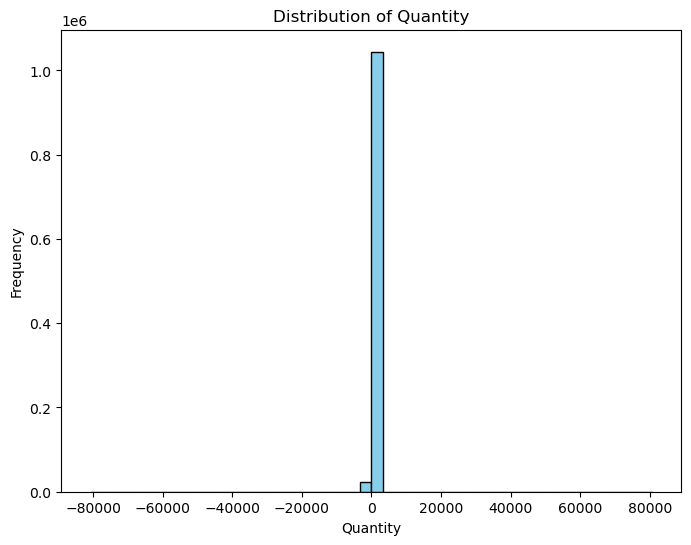

In [6]:
# Plot a histogram of the 'Quantity' feature
plt.figure(figsize=(8, 6))
plt.hist(merged_data['Quantity'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

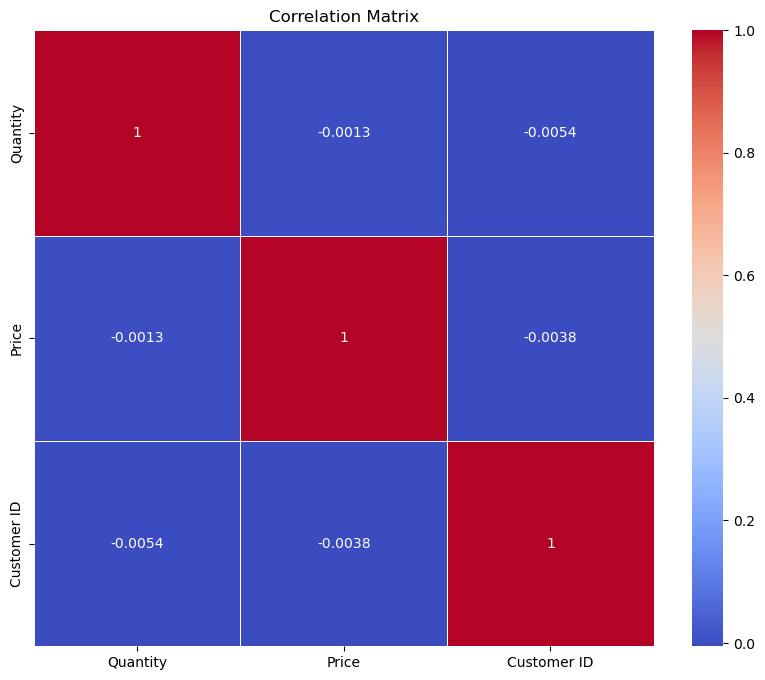

In [7]:
# Calculate and visualize correlations between numeric features
correlation_matrix = merged_data.corr(numeric_only=True)  # Explicitly set numeric_only=True
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()



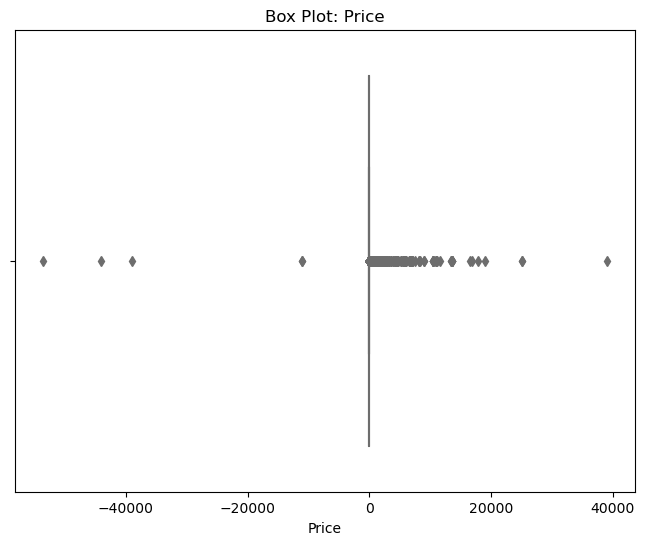

In [8]:
# Outlier Detection
# Visualize outliers in 'Price' using box plots
plt.figure(figsize=(8, 6))
sns.boxplot(x=merged_data['Price'], color='salmon')
plt.title('Box Plot: Price')
plt.xlabel('Price')
plt.show()


In [9]:
# Data Quality Assessment
# Check for unique values in 'Country'
unique_countries = merged_data['Country'].unique()
print("Unique Countries:", unique_countries)

Unique Countries: ['United Kingdom' 'France' 'USA' 'Belgium' 'Australia' 'EIRE' 'Germany'
 'Portugal' 'Japan' 'Denmark' 'Nigeria' 'Netherlands' 'Poland' 'Spain'
 'Channel Islands' 'Italy' 'Cyprus' 'Greece' 'Norway' 'Austria' 'Sweden'
 'United Arab Emirates' 'Finland' 'Switzerland' 'Unspecified' 'Malta'
 'Bahrain' 'RSA' 'Bermuda' 'Hong Kong' 'Singapore' 'Thailand' 'Israel'
 'Lithuania' 'West Indies' 'Lebanon' 'Korea' 'Brazil' 'Canada' 'Iceland'
 'Saudi Arabia' 'Czech Republic' 'European Community']


In [10]:
# Feature Relationships
# Calculate the average 'Price' for each 'Country'
avg_price_by_country = merged_data.groupby('Country')['Price'].mean().sort_values(ascending=False)
print("Average Price by Country:")
print(avg_price_by_country)

Average Price by Country:
Country
Singapore               73.645665
Hong Kong               57.573846
Norway                  28.267979
Malta                   21.991940
RSA                     19.845266
EIRE                     7.013626
Portugal                 6.536580
Sweden                   6.385572
Lebanon                  6.182931
Italy                    5.527679
Channel Islands          5.442788
Spain                    5.389522
Cyprus                   5.386012
United Arab Emirates     5.105060
Finland                  4.990095
European Community       4.820492
Belgium                  4.728428
France                   4.691648
Canada                   4.640746
United Kingdom           4.537892
Unspecified              4.519048
Austria                  4.460896
Australia                4.239974
Greece                   3.922670
Germany                  3.833662
Switzerland              3.778576
Poland                   3.626579
Israel                   3.567305
Bahrain       

In [11]:
# Summary Statistics for Numeric Columns
summary_stats = merged_data.describe()
print("Summary Statistics:")
print(summary_stats)

Summary Statistics:
           Quantity         Price    Customer ID
count  1.067371e+06  1.067371e+06  824364.000000
mean   9.938898e+00  4.649388e+00   15324.638504
std    1.727058e+02  1.235531e+02    1697.464450
min   -8.099500e+04 -5.359436e+04   12346.000000
25%    1.000000e+00  1.250000e+00   13975.000000
50%    3.000000e+00  2.100000e+00   15255.000000
75%    1.000000e+01  4.150000e+00   16797.000000
max    8.099500e+04  3.897000e+04   18287.000000


In [12]:
#check for missing values
missing_values = merged_data.isnull().sum()
missing_values

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [13]:
# Filter the DataFrame to remove rows with negative quantities and prices
merged_data = merged_data[(merged_data['Quantity'] >= 0) & (merged_data['Price'] >= 0)]

# Check the first few rows to verify that negative quantities and prices have been removed
print(merged_data.head())


  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  


In [14]:
# Check for question marks in the DataFrame
contains_question_mark_in_columns = merged_data.astype(str).apply(lambda x: x.str.contains(r'\?')).any()

# Print the columns with question marks
columns_with_question_marks = contains_question_mark_in_columns[contains_question_mark_in_columns].index.tolist()

if columns_with_question_marks:
    print("Question marks are present in the following columns:")
    for column in columns_with_question_marks:
        print(column)
else:
    print("There are no columns with question marks.")


Question marks are present in the following columns:
Description


In [15]:
# Filter the DataFrame to find rows where 'Description' column contains question marks
rows_with_question_marks = merged_data[merged_data['Description'].str.contains(r'\?', na=False)]

# Print the rows where question marks are found
print(rows_with_question_marks)

        Invoice StockCode          Description  Quantity         InvoiceDate  \
63439    495027     21314                    ?      1146 2010-01-20 13:48:00   
307123   519373     21900                    ?      1520 2010-08-16 13:28:00   
309842   519608     48188                    ?       106 2010-08-18 16:25:00   
451858   532332     84944  ?sold individually?       486 2010-11-11 15:43:00   
563722   539494     21479                    ?       752 2010-12-20 10:36:00   
641269   546139     84988                    ?      3000 2011-03-09 16:35:00   
746304   556231    85123A                    ?      4000 2011-06-09 15:04:00   
808343   561665     22171                    ?       142 2011-07-28 16:55:00   
848802   565288     23135                    ?       101 2011-09-02 11:43:00   
946554   572920    72803A                    ?       117 2011-10-26 16:52:00   
1014661  577959     85107               check?       374 2011-11-22 12:11:00   

         Price  Customer ID         Cou

In [16]:
# Data preprocessing(replacing all question marks with an empty string)
merged_data['Description'] = merged_data['Description'].str.replace(r'^\?', '', regex=True) 

In [17]:
# Check for duplicate rows
duplicate_rows = merged_data[merged_data.duplicated()]
if not duplicate_rows.empty:
    print("Duplicate Rows:")
    print(duplicate_rows)
    columns_with_duplicates = duplicate_rows.columns
    print("\nColumns with Duplicate Rows:")
    print(columns_with_duplicates)
else:
    print("No Duplicate Rows Found.")

Duplicate Rows:
        Invoice StockCode                        Description  Quantity  \
371      489517     21912           VINTAGE SNAKES & LADDERS         1   
383      489517     22130   PARTY CONE CHRISTMAS DECORATION          6   
384      489517     22319  HAIRCLIPS FORTIES FABRIC ASSORTED        12   
385      489517     21913     VINTAGE SEASIDE JIGSAW PUZZLES         1   
386      489517     21821   GLITTER STAR GARLAND WITH BELLS          1   
...         ...       ...                                ...       ...   
1067136  581538     22068        BLACK PIRATE TREASURE CHEST         1   
1067150  581538     23318     BOX OF 6 MINI VINTAGE CRACKERS         1   
1067153  581538     22992             REVOLVER WOODEN RULER          1   
1067160  581538     22694                       WICKER STAR          1   
1067162  581538     23343       JUMBO BAG VINTAGE CHRISTMAS          1   

                InvoiceDate  Price  Customer ID         Country  
371     2009-12-01 11:34:00  

In [18]:
# Remove duplicates and reassign to merged_data
merged_data = merged_data.drop_duplicates()

In [19]:
# Check if there are still duplicates in the DataFrame
duplicates_exist = merged_data.duplicated().any()

# Print the result
if duplicates_exist:
    print("There are still duplicates in the DataFrame.")
else:
    print("There are no duplicates in the DataFrame.")

There are no duplicates in the DataFrame.


In [20]:
# Feature Engineering: Create 'Recency' feature
merged_data['InvoiceDate'] = pd.to_datetime(merged_data['InvoiceDate'], format='%d/%m/%Y %H:%M')
end_of_2011 = pd.to_datetime('2011-12-31')
merged_data['Recency'] = (end_of_2011 - merged_data['InvoiceDate']).dt.days

In [21]:
# Filter data for cleaning and analysis
cleaned_data = merged_data.dropna(
    subset=["Invoice", "Description", "Customer ID", "StockCode", "Price", "InvoiceDate", "Country", "Quantity"]
).copy()

In [22]:
#check if there are still missing values
missing_values = cleaned_data.isnull().sum()
missing_values

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
Recency        0
dtype: int64

In [23]:
# Create a feature matrix for customer segmentation
rfm_data = cleaned_data.groupby('Customer ID').agg({
    'Invoice': 'nunique',  # Count unique invoices per customer
    'Price': 'sum',
    'Quantity': 'sum',   # Sum of quantities per customer
    'InvoiceDate': 'max',  # Latest invoice date per customer
    'Country': 'nunique'   # Count of unique countries per customer
})

In [24]:
# Rename the columns for clarity
rfm_data.rename(columns={'Invoice': 'UniqueInvoices', 'Price': 'Monetary', 'Quantity': 'TotalQuantity',
                        'InvoiceDate': 'LatestInvoiceDate', 'Country': 'UniqueCountries'}, inplace=True)

# Convert 'LatestInvoiceDate' to a pandas datetime format
rfm_data['LatestInvoiceDate'] = pd.to_datetime(rfm_data['LatestInvoiceDate'], format='%d/%m/%Y %H:%M')

# Calculate Recency as days since the end of 2011
end_of_2011 = pd.to_datetime('2011-12-31')
rfm_data['Recency'] = (end_of_2011 - rfm_data['LatestInvoiceDate']).dt.days

In [25]:
# Standardize the data
scaler = StandardScaler()
scaled_rfm_data = scaler.fit_transform(rfm_data[['UniqueInvoices', 'Monetary', 'TotalQuantity', 'Recency']])

In [26]:
# Define a Z-Score threshold for outlier removal
z_threshold = 2
# Calculate Z-Scores for each feature
z_scores = np.abs(stats.zscore(scaled_rfm_data, axis=0))

# Filter out rows with Z-Scores above the threshold in scaled_rfm_data
scaled_rfm_data = scaled_rfm_data[(z_scores < z_threshold).all(axis=1)]
# Define filtered_indices
filtered_indices = np.where((z_scores < z_threshold).all(axis=1))[0]
rfm_data = rfm_data.iloc[filtered_indices].copy()

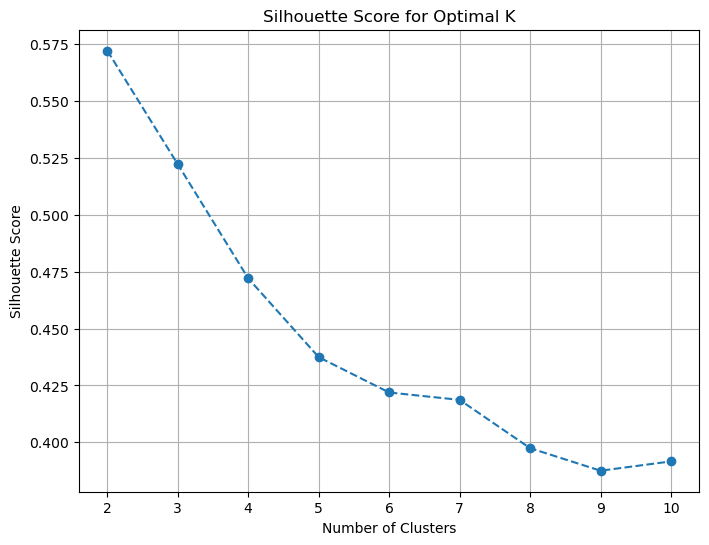

Optimal number of clusters (K): 2


In [27]:
# Determine the optimal number of clusters using the Silhouette Score
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_rfm_data)
    silhouette_scores.append(silhouette_score(scaled_rfm_data, cluster_labels))

# Plot the Silhouette Scores to find the optimal number of clusters
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.grid(True)
plt.show()

# Choose the optimal number of clusters (K)
k = np.argmax(silhouette_scores) + 2
print(f"Optimal number of clusters (K): {k}")

# Apply K-Means clustering
kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
rfm_data['Cluster'] = kmeans.fit_predict(scaled_rfm_data)
rfm_data['Cluster'] = rfm_data['Cluster'].astype(str)


         UniqueInvoices    Monetary  UniqueCountries     Recency  \
Cluster                                                            
0              6.454163  414.851077         1.003084   82.262125   
1              2.335534  149.053956         1.001100  429.408141   

         CustomerCount  
Cluster                 
0                 3567  
1                 1818  


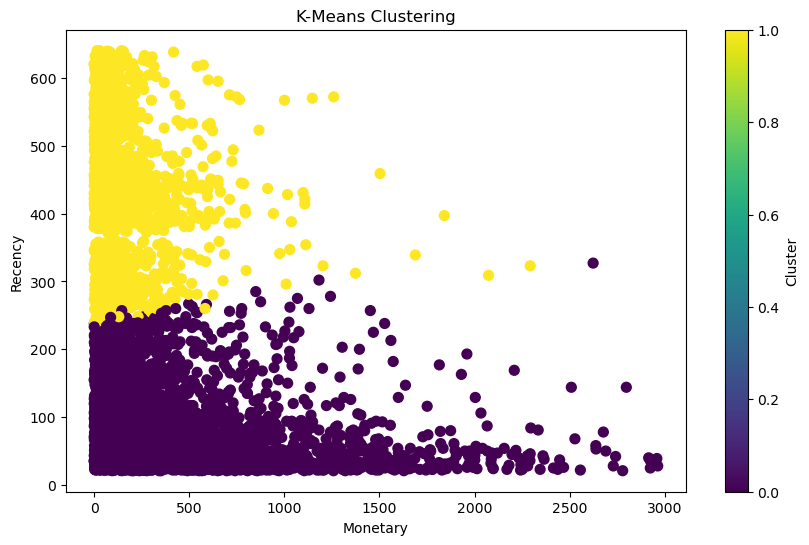

             Cluster
Customer ID         
12347.0            0
12348.0            0
12349.0            0
12350.0            1
12351.0            1


In [28]:

# Analyze and visualize the segments
segment_summary = rfm_data.groupby('Cluster').agg({
    'UniqueInvoices': 'mean',
    'Monetary': 'mean',
    'UniqueCountries': 'mean',
    'Recency': 'mean',
    'Cluster': 'size'
})
segment_summary.rename(columns={'Cluster': 'CustomerCount'}, inplace=True)
print(segment_summary)

# Convert the 'Cluster' column to numeric values
rfm_data['Cluster'] = rfm_data['Cluster'].astype(int)

# Scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(rfm_data['Monetary'], rfm_data['Recency'], c=rfm_data['Cluster'], cmap='viridis', s=50)
plt.xlabel('Monetary')
plt.ylabel('Recency')
plt.title('K-Means Clustering')
plt.colorbar(label='Cluster')
plt.show()

# Print a sample of the data to see the cluster assignments
print(rfm_data[['Cluster']].head())

In [29]:
# Define churn based on a threshold (e.g., 90 days without a purchase)
rfm_data['Churn'] = rfm_data['Recency'] > 90

# Split data for classification
X_cls = rfm_data[['UniqueInvoices', 'Monetary', 'TotalQuantity', 'Recency']]
y_cls = rfm_data['Churn']

# Initialize the Random Forest Classifier
classifier = RandomForestClassifier(random_state=42)

# Define the parameter grid to search
param_grid_cls = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
# Use cross-validation to check for overfitting
cv_cls = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(classifier, X_cls, y_cls, cv=cv_cls, scoring='accuracy')

print("Cross-Validation Accuracy Scores:", cross_val_scores)
print(f"Mean Cross-Validation Accuracy: {np.mean(cross_val_scores):.4f}")

# Split the data into train and test sets for final evaluation
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

# Initialize GridSearchCV with cross-validation for classification
grid_search_cls = GridSearchCV(estimator=classifier, param_grid=param_grid_cls, cv=cv_cls, scoring='accuracy',
                               n_jobs=-1)

# Fit the grid search to the data for classification
grid_search_cls.fit(X_train_cls, y_train_cls)

# Extract the best model from GridSearchCV for classification
best_classifier = grid_search_cls.best_estimator_

# Make predictions on the test set for classification
y_pred_cls = best_classifier.predict(X_test_cls)

# Evaluate the classification model's performance on the test set
accuracy_cls = accuracy_score(y_test_cls, y_pred_cls)
confusion_matrix_cls = confusion_matrix(y_test_cls, y_pred_cls)
classification_report_cls = classification_report(y_test_cls, y_pred_cls)

print("Classification Model Metrics:")
print(f"Accuracy: {accuracy_cls:.4f}")
print("Confusion Matrix:\n", confusion_matrix_cls)
print("Classification Report:\n", classification_report_cls)

# Calculate the generalization error using the model's performance on the test set
generalization_error_cls = 1 - accuracy_cls
print(f"Generalization Error on Test Set: {generalization_error_cls:.4f}")


Cross-Validation Accuracy Scores: [1. 1. 1. 1. 1.]
Mean Cross-Validation Accuracy: 1.0000
Classification Model Metrics:
Accuracy: 1.0000
Confusion Matrix:
 [[469   0]
 [  0 608]]
Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00       469
        True       1.00      1.00      1.00       608

    accuracy                           1.00      1077
   macro avg       1.00      1.00      1.00      1077
weighted avg       1.00      1.00      1.00      1077

Generalization Error on Test Set: 0.0000


Feature Importances (Descending Order):
          Feature  Importance
3         Recency    0.902230
0  UniqueInvoices    0.067130
1        Monetary    0.018086
2   TotalQuantity    0.012553


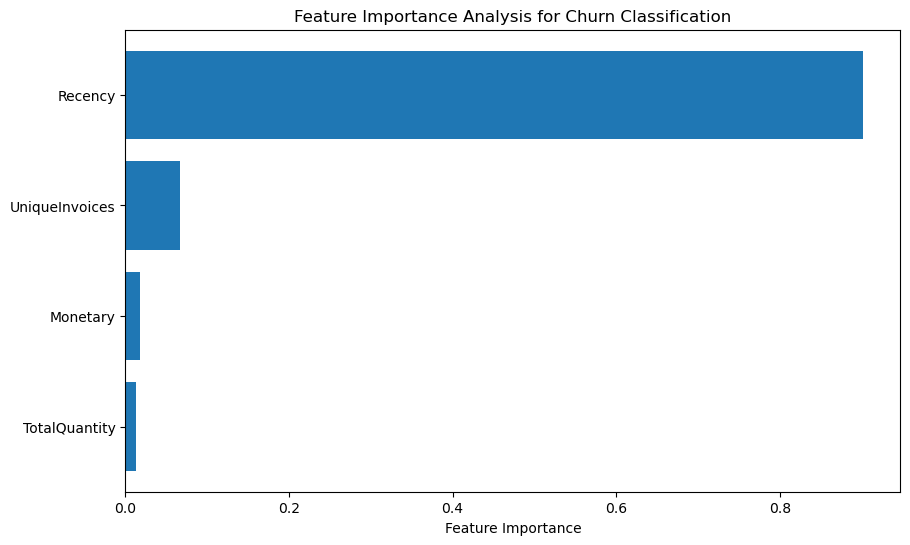

In [30]:
# Show feature importances for classification
feature_importances_cls = best_classifier.feature_importances_

# Create a DataFrame to store feature names and their importances
feature_importance_df_cls = pd.DataFrame({'Feature': X_cls.columns, 'Importance': feature_importances_cls})

# Sort the DataFrame by importance in descending order
feature_importance_df_cls = feature_importance_df_cls.sort_values(by='Importance', ascending=False)

# Print the feature importances in order of importance
print("Feature Importances (Descending Order):")
print(feature_importance_df_cls)

# Plot the feature importances for classification
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df_cls['Feature'], feature_importance_df_cls['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance Analysis for Churn Classification')
plt.gca().invert_yaxis()  # Invert the y-axis to show most important features at the top
plt.show()
